In [1]:
!pip install opencv-python
!pip install tensorflow

In [2]:
!pip install pillow

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets list

ref                                                                  title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------------  --------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
amar5693/screen-time-sleep-and-stress-analysis-dataset               Screen Time, Sleep & Stress Analysis Dataset            787136  2026-02-13 06:56:18.757000           6993        139  1.0              
amar5693/student-performance-dataset                                 Student Performance Dataset                             177286  2026-02-12 06:04:44.613000           6013         97  1.0              
aliiihussain/amazon-sales-dataset                                    Amazon_Sales_Dataset                                   1297759  2026-02-01 11:37:12.353000           8639      

In [6]:
!kaggle datasets download -d jangedoo/utkface-new

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
utkface-new.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
import zipfile

with zipfile.ZipFile("utkface-new.zip","r") as zip_ref:
    zip_ref.extractall("dataset")

In [8]:
dataset_path = "/content/dataset/UTKFace"

In [9]:
import os
print(len(os.listdir(dataset_path)))

23708


In [10]:
images =[]
age_labels = []
gender_labels = []

In [11]:
limit = 8000   # IMPORTANT

for img_name in tqdm(os.listdir(dataset_path)[:limit]):

    try:
        parts = img_name.split('_')

        age = int(parts[0])
        gender = int(parts[1])

        img_path = os.path.join(dataset_path, img_name)
        img = cv2.imread(img_path)

        if img is None:
            continue

        img = cv2.resize(img,(128,128))

        images.append(img)
        age_labels.append(age)
        gender_labels.append(gender)

    except:
        continue

100%|██████████| 8000/8000 [00:02<00:00, 3162.93it/s]


In [12]:
images = np.array(images)/255.0
age_labels = np.array(age_labels)
gender_labels = np.array(gender_labels)

print(images.shape)
print(age_labels.shape)
print(gender_labels.shape)

(8000, 128, 128, 3)
(8000,)
(8000,)


In [13]:
from sklearn.model_selection import train_test_split

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_age_train, y_age_test, y_gender_train, y_gender_test = train_test_split(
    images, age_labels, gender_labels,
    test_size=0.2,
    random_state=42
)

In [15]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

input_layer = Input(shape=(128,128,3))

x = Conv2D(32,(3,3),activation='relu')(input_layer)
x = MaxPooling2D()(x)

x = Conv2D(64,(3,3),activation='relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(128,(3,3),activation='relu')(x)
x = MaxPooling2D()(x)

x = Flatten()(x)
x = Dense(128,activation='relu')(x)

# outputs
age_output = Dense(1,name="age")(x)
gender_output = Dense(1,activation='sigmoid',name="gender")(x)

model = Model(inputs=input_layer, outputs=[age_output, gender_output])

In [16]:
model.compile(
    optimizer='adam',
    loss={
        'age':'mae',
        'gender':'binary_crossentropy'
    },
    metrics={
        'gender':'accuracy'
    }
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 126, 126,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 63, 63,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 61,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 30, 30,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 14, 14,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 25088)     │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │  3,211,392 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age (Dense)         │ (None, 1)         │        129 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender (Dense)      │ (None, 1)         │        129 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,304,898 (12.61 MB)

 Trainable params: 3,304,898 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history = model.fit(
    X_train,
    {'age':y_age_train, 'gender':y_gender_train},
    validation_data=(X_test, {'age':y_age_test, 'gender':y_gender_test}),
    epochs=15,
    batch_size=32
)

Epoch 1/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - age_loss: 16.7238 - gender_accuracy: 0.5707 - gender_loss: 0.7573 - loss: 17.4811 - val_age_loss: 14.3809 - val_gender_accuracy: 0.7106 - val_gender_loss: 0.5743 - val_loss: 14.9552
Epoch 2/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - age_loss: 13.1521 - gender_accuracy: 0.7165 - gender_loss: 0.5549 - loss: 13.7071 - val_age_loss: 11.6715 - val_gender_accuracy: 0.8119 - val_gender_loss: 0.4292 - val_loss: 12.1007
Epoch 3/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - age_loss: 10.8438 - gender_accuracy: 0.8089 - gender_loss: 0.4143 - loss: 11.2582 - val_age_loss: 10.8046 - val_gender_accuracy: 0.8075 - val_gender_loss: 0.4303 - val_loss: 11.2349
Epoch 4/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - age_loss: 10.0622 - gender_accuracy: 0.8325 - gender_loss: 0.3835 - loss: 10.4457 - val_age_loss: 10.1089 - val_gender_accuracy: 0.8363 - val_gender_loss: 0.3881 - val_loss: 10.4970
Epoch 5/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/ste

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
Predicted Age: 27
Gender: Male


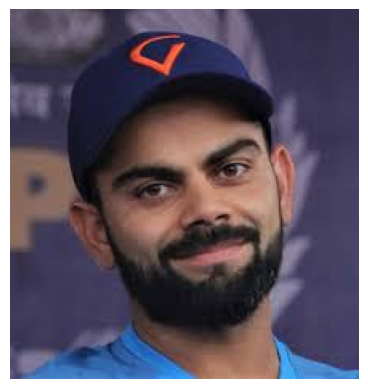

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img_path = "/content/images.jpeg"   # change name
img = cv2.imread(img_path)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")

# resize same as training
face = cv2.resize(img,(128,128))
face = face/255.0
face = face.reshape(1,128,128,3)

age_pred, gender_pred = model.predict(face)

print("Predicted Age:", int(age_pred[0][0]))
print("Gender:", "Male" if gender_pred[0][0] < 0.5 else "Female")

In [19]:
import cv2

face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
)

img = cv2.imread("/content/images.jpeg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

faces = face_cascade.detectMultiScale(gray,1.3,5)

for (x,y,w,h) in faces:
    face = img[y:y+h, x:x+w]

face = cv2.resize(face,(128,128))
face = face/255.0
face = face.reshape(1,128,128,3)

age_pred, gender_pred = model.predict(face)

print("Age:",int(age_pred[0][0]))
print("Gender:", "Male" if gender_pred[0][0]<0.5 else "Female")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Age: 29
Gender: Male


In [20]:
!pip install streamlit

In [21]:
import streamlit as st
import cv2
import numpy as np
from tensorflow.keras.models import load_model

st.title("Age & Gender Detection AI")

uploaded = st.file_uploader("Upload image")

if uploaded:
    file_bytes = np.asarray(bytearray(uploaded.read()), dtype=np.uint8)
    img = cv2.imdecode(file_bytes, 1)

    st.image(img, channels="BGR")

    face_cascade = cv2.CascadeClassifier(
        cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
    )

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray,1.3,5)

    for (x,y,w,h) in faces:
        face = img[y:y+h, x:x+w]

    face = cv2.resize(face,(128,128))
    face = face/255.0
    face = face.reshape(1,128,128,3)

    age_pred, gender_pred = model.predict(face)

    st.write("Predicted Age:", int(age_pred[0][0]))
    st.write("Gender:", "Male" if gender_pred[0][0]<0.5 else "Female")

2026-02-26 05:31:33.432 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-26 05:31:34.185 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2026-02-26 05:31:34.186 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-26 05:31:34.187 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-26 05:31:34.189 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-26 05:31:34.190 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-26 05:31:34.191 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-26 05:31:34.193 Thread 'MainThread': mi

In [32]:
model.save("age_gender_model.h5")

In [23]:
%%writefile app.py
import streamlit as st
import cv2
import numpy as np
from tensorflow.keras.models import load_model

model = load_model("age_gender_model.h5")

st.title("Age & Gender Detection AI")

uploaded = st.file_uploader("Upload image")

if uploaded:
    file_bytes = np.asarray(bytearray(uploaded.read()), dtype=np.uint8)
    img = cv2.imdecode(file_bytes, 1)

    st.image(img, channels="BGR")

    face_cascade = cv2.CascadeClassifier(
        cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
    )

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray,1.3,5)

    for (x,y,w,h) in faces:
        face = img[y:y+h, x:x+w]

    face = cv2.resize(face,(128,128))
    face = face/255.0
    face = face.reshape(1,128,128,3)

    age_pred, gender_pred = model.predict(face)

    st.write("Predicted Age:", int(age_pred[0][0]))
    st.write("Gender:", "Male" if gender_pred[0][0]<0.5 else "Female")

Overwriting app.py


In [24]:
!streamlit run app.py & npx localtunnel --port 8501

⠙⠹⠸

⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧your url is: https://heavy-crabs-go.loca.lt

  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.16.135.222:8501

  Stopping...
^C


In [25]:
!curl ipv4.icanhazip.com

34.16.135.222


In [26]:
!pip install streamlit pyngrok

In [27]:
from pyngrok import ngrok

!streamlit run app.py &>/dev/null&

public_url = ngrok.connect(8501)
public_url

ERROR:pyngrok.process.ngrok:t=2026-02-26T05:32:10+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"


PyngrokNgrokError: The ngrok process errored on start: authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n.

In [28]:
!ngrok config add-authtoken 3AC62JyWEmmtQ6ujARF2ii06HT4_2KrgFBe6bZraEt753MK8

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [29]:
from pyngrok import ngrok
!streamlit run app.py &>/dev/null&

public_url = ngrok.connect(8501)
print(public_url)

NgrokTunnel: "https://supereligible-katina-inattentively.ngrok-free.dev" -> "http://localhost:8501"


In [33]:
model = load_model("age_gender_model.h5", compile=False)

In [34]:
from pyngrok import ngrok
!streamlit run app.py &>/dev/null&
public_url = ngrok.connect(8501)
public_url

<NgrokTunnel: "https://supereligible-katina-inattentively.ngrok-free.dev" -> "http://localhost:8501">